In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import decode_image
from torchvision import models
import os
import pandas as pd
import torchvision.transforms.v2 as T
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{self.img_labels.iloc[idx, 0]}.jpg")
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
def transform_target(label):
    brand_to_idx = {
        "adidas": 0,
        "converse": 1,
        "nike": 2,
    }
    return brand_to_idx[label]

transform = T.Compose([
    T.Resize(227),
    T.CenterCrop(227),
    T.ToDtype(torch.float32, scale=True),
])

training_data = CustomImageDataset(annotations_file="data/train/annotations.csv", img_dir="data/train/images", transform=transform,target_transform=transform_target)

testing_data = CustomImageDataset(annotations_file="data/test/annotations.csv", img_dir="data/test/images", transform=transform, target_transform=transform_target)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=64, shuffle=False)

In [72]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=3)

In [73]:
for param in model.parameters():
    param.requires_grad_(False)

In [51]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [74]:
model.classifier.requires_grad_(True)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

In [75]:
for name, param in model.classifier.named_parameters():
    print(name, param.requires_grad)

1.weight True
1.bias True
4.weight True
4.bias True
6.weight True
6.bias True


In [76]:
if torch.cuda.is_available():
  model.to("cuda")
else:
  model.to("cpu")

In [77]:
from torch import nn

epochs = 20
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [78]:
def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    y_true = []
    y_preds= []
    number_of_batches = len(train_dataloader)
    pbar = tqdm(train_dataloader, total=number_of_batches)
    i = 0
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for  data in pbar:
        # Every data instance is an input + label pair
        inputs, labels = data
        y_true = y_true + list(labels.cpu().numpy())
        # Zero your gradients for every batch!
        optim.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        y_preds = y_preds + list(torch.max(outputs, 1).indices.cpu().numpy())

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optim.step()

        # Gather data and report
        running_loss += loss.item()
        
        # last_loss = running_loss / 1000 # loss per batch
        # print(f'batch {i + 1}/{number_of_batches} loss: {loss.item():.2f}', end="")
        i += 1
        pbar.set_description(f"Batch {i}/{number_of_batches} Loss: {loss.item():.3f}")
    acc = accuracy_score(y_true, y_preds)
    # print(f"Training accuracy: {acc}")
    return running_loss / number_of_batches, acc

In [79]:
accs_train = []
accs_test = []

losses_train = []
losses_test = []
for epoch in range(epochs):
  print('EPOCH {}:'.format(epoch + 1))

  # Make sure gradient tracking is on, and do a pass over the data
  model.train(True)
  avg_loss, acc_train = train_one_epoch()


  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  preds = []
  true = []

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(test_dataloader):
          vinputs, vlabels = vdata
          voutputs = model(vinputs)
          preds = preds + list(torch.max(voutputs, 1).indices.cpu().numpy())
          true = true + list(vlabels.cpu().numpy())
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss.item()
  acc = accuracy_score(true, preds)
  avg_vloss = running_vloss / (i + 1)
  print(f'LOSS train {avg_loss} valid {avg_vloss}')
  print(f'ACCURACY train {acc_train} valid {acc}')

  losses_train.append(avg_loss)
  losses_test.append(avg_vloss)
  accs_train.append(acc_train)
  accs_test.append(acc)

EPOCH 1:


Batch 12/12 Loss: 0.859: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


LOSS train 1.703527604540189 valid 0.9711711406707764
ACCURACY train 0.39436619718309857 valid 0.4247787610619469
EPOCH 2:


Batch 12/12 Loss: 1.335: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


LOSS train 1.0198534280061722 valid 0.7404477298259735
ACCURACY train 0.5507042253521127 valid 0.6548672566371682
EPOCH 3:


Batch 12/12 Loss: 1.049: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


LOSS train 0.7173229306936264 valid 0.601372554898262
ACCURACY train 0.7028169014084507 valid 0.7345132743362832
EPOCH 4:


Batch 12/12 Loss: 1.372: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


LOSS train 0.5604271590709686 valid 0.8911975026130676
ACCURACY train 0.8056338028169014 valid 0.6194690265486725
EPOCH 5:


Batch 12/12 Loss: 0.049: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


LOSS train 0.3769228681921959 valid 0.5769636780023575
ACCURACY train 0.8253521126760563 valid 0.8053097345132744
EPOCH 6:


Batch 12/12 Loss: 0.054: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


LOSS train 0.26412667830785114 valid 2.2660741806030273
ACCURACY train 0.8830985915492958 valid 0.5486725663716814
EPOCH 7:


Batch 12/12 Loss: 0.104: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


LOSS train 0.4800895632555087 valid 0.6236088275909424
ACCURACY train 0.8295774647887324 valid 0.7256637168141593
EPOCH 8:


Batch 12/12 Loss: 0.091: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


LOSS train 0.19610358898838362 valid 0.5876551419496536
ACCURACY train 0.9267605633802817 valid 0.831858407079646
EPOCH 9:


Batch 12/12 Loss: 0.025: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


LOSS train 0.1365320022838811 valid 0.8604417443275452
ACCURACY train 0.9450704225352112 valid 0.8141592920353983
EPOCH 10:


Batch 12/12 Loss: 0.033: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


LOSS train 0.09958252202098568 valid 0.639222264289856
ACCURACY train 0.9619718309859155 valid 0.8141592920353983
EPOCH 11:


Batch 12/12 Loss: 0.052: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


LOSS train 0.09480961920538296 valid 0.7111677825450897
ACCURACY train 0.9605633802816902 valid 0.8141592920353983
EPOCH 12:


Batch 12/12 Loss: 0.006: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


LOSS train 0.08744810727269699 valid 0.8429729044437408
ACCURACY train 0.971830985915493 valid 0.7964601769911505
EPOCH 13:


Batch 12/12 Loss: 0.003: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


LOSS train 0.08447620872175321 valid 1.947704017162323
ACCURACY train 0.9704225352112676 valid 0.6902654867256637
EPOCH 14:


Batch 12/12 Loss: 0.001: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


LOSS train 0.12725853661443884 valid 0.613364040851593
ACCURACY train 0.9507042253521126 valid 0.8141592920353983
EPOCH 15:


Batch 12/12 Loss: 0.267: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


LOSS train 0.11282171572869022 valid 0.8530043065547943
ACCURACY train 0.9647887323943662 valid 0.8053097345132744
EPOCH 16:


Batch 12/12 Loss: 0.001: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


LOSS train 0.12208708193793427 valid 0.7625879347324371
ACCURACY train 0.9549295774647887 valid 0.831858407079646
EPOCH 17:


Batch 12/12 Loss: 0.005: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


LOSS train 0.05245771092207482 valid 0.954215407371521
ACCURACY train 0.9802816901408451 valid 0.8495575221238938
EPOCH 18:


Batch 12/12 Loss: 0.000: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


LOSS train 0.06645096166418323 valid 1.001074194908142
ACCURACY train 0.9774647887323944 valid 0.831858407079646
EPOCH 19:


Batch 12/12 Loss: 0.000: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


LOSS train 0.045108581924675185 valid 0.8931028842926025
ACCURACY train 0.9859154929577465 valid 0.8053097345132744
EPOCH 20:


Batch 12/12 Loss: 0.287: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


LOSS train 0.08820771212534358 valid 1.214333951473236
ACCURACY train 0.9732394366197183 valid 0.7876106194690266


In [80]:
torch.save(model, 'model.pth')

In [81]:
plt.style.use('ggplot')

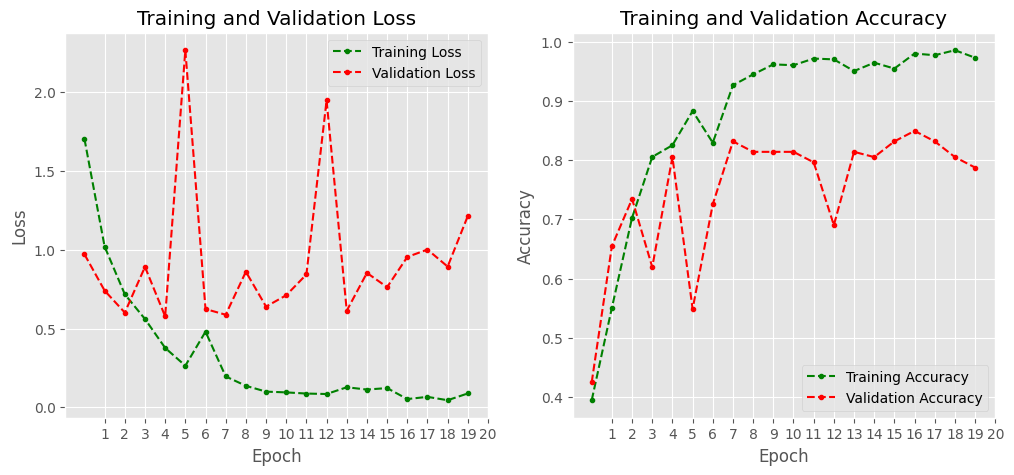

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train, "g.--", label='Training Loss')
plt.plot(losses_test, "r.--" ,label='Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(1, epochs+1))
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accs_train, "g.--", label='Training Accuracy')
plt.plot(accs_test, "r.--" ,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(1, epochs+1))
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('training_validation_metrics.png', dpi=800, transparent=True)
plt.show()